## **Random Walker Algorithm**

Based in the research papers and other documentation below:
1. http://vision.cse.psu.edu/people/chenpingY/paper/grady2006random.pdf
2. https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_random_walker_segmentation.html


### Mounting the Google Drive for Data Extraction

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Necessary imports

In [28]:
import os
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt

In [29]:
Path = "drive/MyDrive/Dataset_A4/" # The path to our images folder in the mounted GDrive

In [30]:
images = [] #Storing the images
for i in range(10):
  images.append(cv2.imread(Path + str(i) + '.png', cv2.IMREAD_GRAYSCALE)) # Adding individual images to our image array

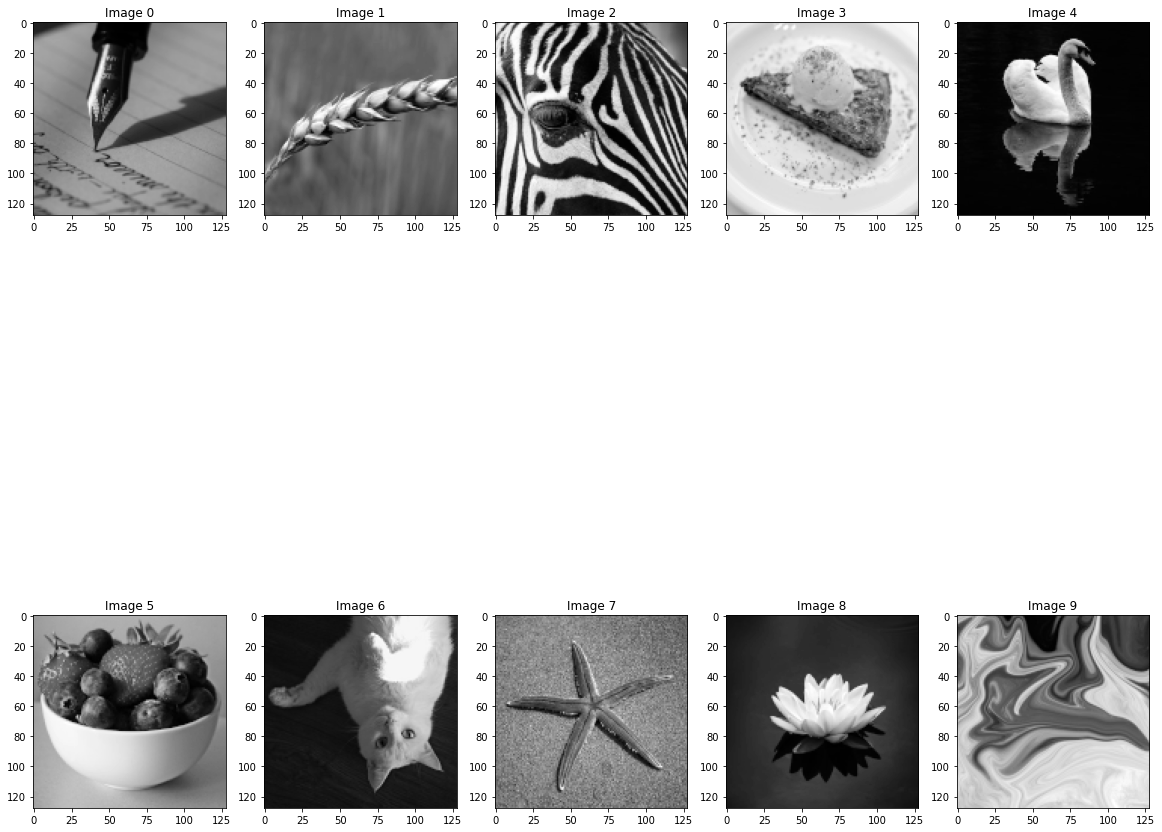

In [31]:
fig, axes = plt.subplots(2,5,figsize=(20,20)) # Plotting the dataset images
for i in range(10):
  if(i<5):
    axes[0][i%5].imshow(images[i], cmap = "gray")
    axes[0][i%5].title.set_text(f'Image {i}')
  else:
    axes[1][i%5].imshow(images[i], cmap = "gray")
    axes[1][i%5].title.set_text(f'Image {i}')
plt.show()
# image = cv2.imread(data +str(1)+'.png', cv2.IMREAD_GRAYSCALE)
# plt.imshow(image, cmap="gray")

In [32]:
from skimage.restoration import denoise_nl_means, estimate_sigma
# denoise_nl_means - Perform non-local means denoising on 2D-4D grayscale or RGB images. Returns the denoised image.
#estimate_sigma - Estimates the noise standard deviation of a Gaussian. Returns the Estimated noise standard deviation.
from skimage import exposure

def init_denoise(image):
  image = image/255.0 # This normalizes the image i.e. brings it to 0-1 range
  estimated_sigma = np.mean(estimate_sigma(image, multichannel=True))
  denoised_img = denoise_nl_means(image, h=0.8 * estimated_sigma,sigma=estimated_sigma, fast_mode=False, 
                                  patch_size=5, # Size of patches used for denoising.
                                  patch_distance=6, # Maximal distance in pixels where to search patches used for denoising.
                                  multichannel=True)
  equi_image = exposure.equalize_adapthist(denoised_img)

  return equi_image

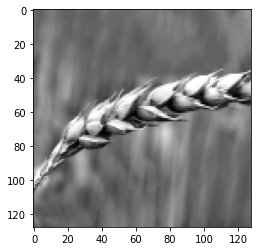

In [33]:
plt.imshow(init_denoise(images[1]), cmap="gray") # Plotting the denoised image

In [12]:
def marking(equi_image): # Marking the pixel/seeds for image segmentation using random walk algorithm
  marked = np.zeros((128,128), dtype = np.uint64)
  marked[(equi_image < 0.6) & (equi_image > 0.3)] = 1
  marked[(equi_image > 0.8) & (equi_image < 0.99)] = 2
  return marked

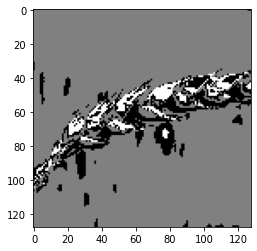

In [13]:
plt.imshow(marking(init_denoise(images[1])), cmap="gray")

In [21]:
height, width = images[1].shape[:2]

### Random Walker Algorithm

In [ ]:
from math import exp
def weight_function(image, ref, beta): # The weight function in the paper.
  return exp(-1*((image - ref)**2)*beta)

In [22]:
def random_walker_algo(image, segments, beta): # # # Defined Random Walker based on the segmentation.
  final_image = np.zeros((height,width))
  for y in range(image.shape[1]):
    for x in range(image.shape[0]):
      wt_0 = weight_function(image[x][y], 0, beta)
      wt_1 = weight_function(image[x][y], 1, beta)

      if((wt_0 > wt_1) & (wt_0 > 0.6)): # Choosing a required threshold
        final_image[x][y] = 1

      elif((wt_1 > wt_0) & (wt_1 > 0.6)):
        final_image[x][y]  = 2

    labels = final_image
    # Classification of the pixels in one of the two segments
    segment_1 = (labels==1)
    segment_2 = (labels==2) 
    all_segments = np.zeros((height, width))
    # Final assignmnet of the pixel values
    all_segments[segment_1] = 0
    all_segments[segment_2] = 1 
  return all_segments



### Our Algorithm

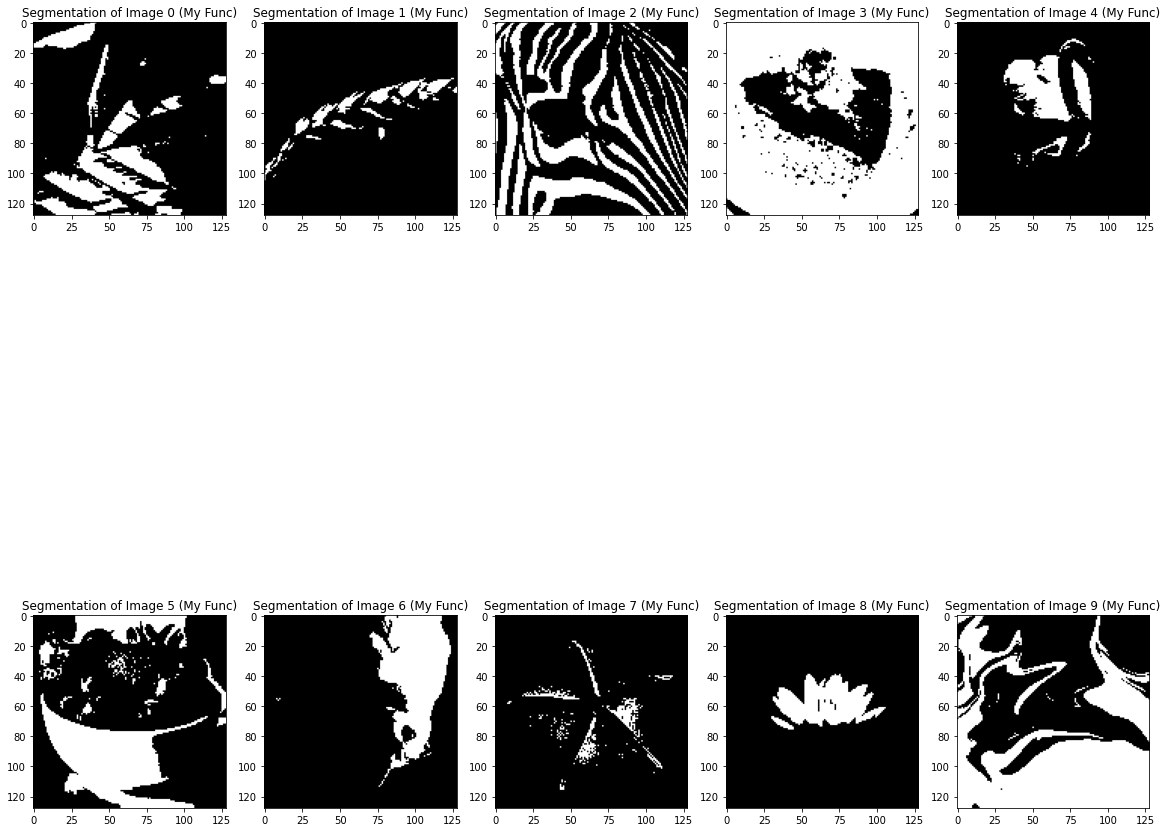

In [26]:
fig, axes = plt.subplots(2, 5, figsize=(20,20))
for i in range(10):
  equi_image = init_denoise(images[i])
  marked = marking(equi_image)
  all_segments = random_walker_algo(equi_image, marked, beta=10)
  if(i<5):
    axes[0][i%5].imshow(all_segments, cmap = "gray")
    axes[0][i%5].title.set_text(f'Segmentation of Image {i} (My Func)')
  else:
    axes[1][i%5].imshow(all_segments, cmap = "gray")
    axes[1][i%5].title.set_text(f'Segmentation of Image {i} (My Func)')

### Comparison with Scikit-Learn implementation of Random Walker

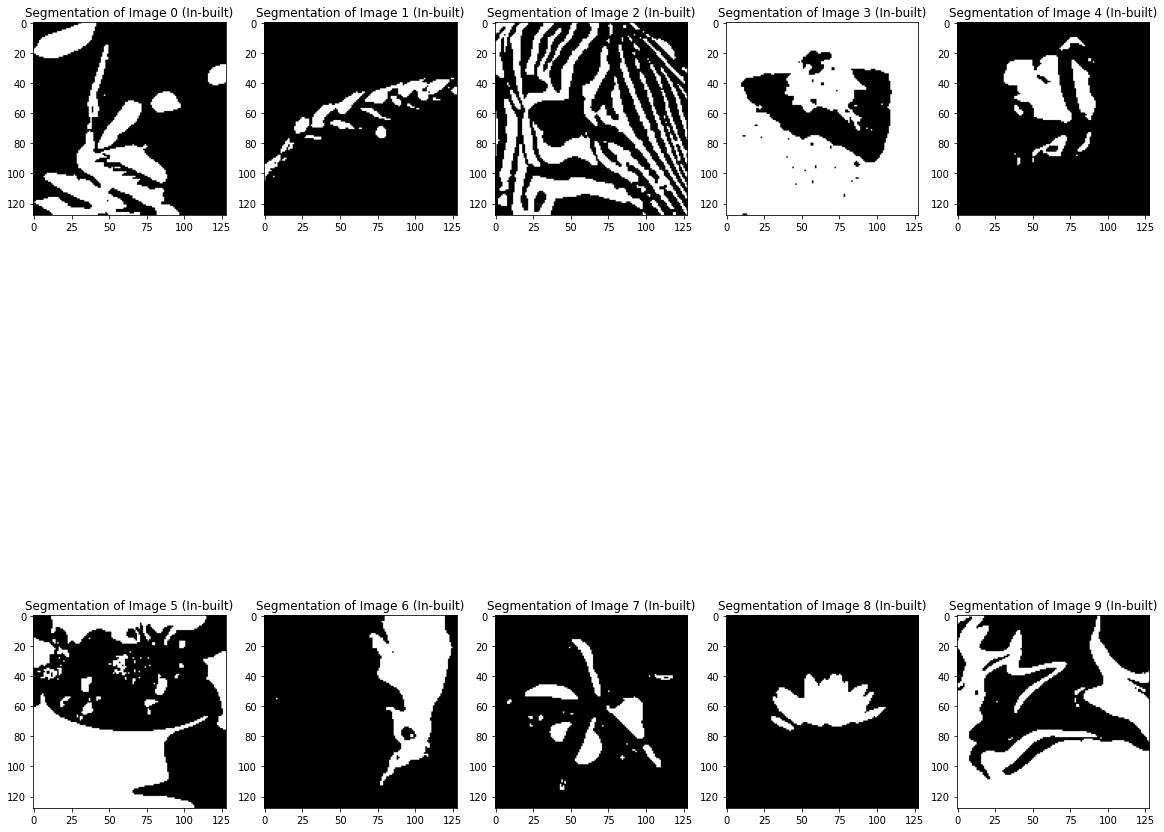

In [27]:
from skimage.segmentation import random_walker
fig, axes = plt.subplots(2, 5, figsize=(20,20))
inbmatrix = []
for i in range(10):
  equi_image = init_denoise(images[i])
  marked = marking(equi_image)
  labels = random_walker(equi_image, marked, beta=10, mode="bf")

  seg1 = (labels==1)
  seg2 = (labels==2)

  all_segments_rw = np.zeros((height, width))
  all_segments_rw[seg1] = 0
  all_segments_rw[seg2] = 1
  if(i<5):
    axes[0][i%5].imshow(all_segments_rw, cmap = "gray")
    axes[0][i%5].title.set_text(f'Segmentation of Image {i} (In-built)')
  else:
    axes[1][i%5].imshow(all_segments_rw, cmap = "gray")
    axes[1][i%5].title.set_text(f'Segmentation of Image {i} (In-built)')